# Project 1 Solution

# Purpose

I have two goals for this project:

1. To help you master data manipulation and visualization
1. To help you understand the risk-return tradeoff for several measures of risk

# Tasks

## Packages and Settings

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

## Data

I used the following code cell to download the data for this project.
Leave this code cell commented out and use the CSV files I provided with this notebook.

In [3]:
# import yfinance as yf
# import pandas_datareader as pdr
# import requests_cache
# session = requests_cache.CachedSession(expire_after=1)

In [4]:
# wiki = pd.read_html('https://en.wikipedia.org/wiki/Russell_1000_Index')

In [5]:
# (
#     yf.Tickers(
#         tickers=wiki[2]['Ticker'].str.replace(pat='.', repl='-', regex=False).to_list(),
#         session=session
#     )
#     .history(period='max', auto_adjust=False)
#     .assign(Date = lambda x: x.index.tz_localize(None))
#     .set_index('Date')
#     .rename_axis(columns=['Variable', 'Ticker'])
#     ['Adj Close']
#     .pct_change()
#     .loc['1962':'2022']
#     .to_csv('returns.csv')
# )

In [6]:
# (
#     pdr.DataReader(
#         name='F-F_Research_Data_Factors_daily',
#         data_source='famafrench',
#         start='1900',
#         session=session
#     )
#     [0]
#     .rename_axis(columns='Variable')
#     .div(100)
#     .loc['1962':'2022']
#     .to_csv('ff.csv')
# )

Run the following code cell to read the data for this project.
The `returns.csv` file contains daily returns for the Russell 1000 stocks from 1962 through 2022, and the `ff.csv` contains daily Fama and French factors from 1962 through 2022.

In [7]:
returns = pd.read_csv('returns.csv', index_col='Date', parse_dates=True)
ff = pd.read_csv('ff.csv', index_col='Date', parse_dates=True)

## Single Stocks

For this section, use the single stock returns in `returns`.
You may select years $t$ and $t+1$, but only use stocks with complete returns data for years $t$ and $t+1$.

### Task 1: Do mean returns in year $t$ predict mean returns in year $t+1$?

In [8]:
time = 2018
time, timep1 = str(time), str(time + 1)

In [9]:
def mean(ri, ann=252, mul=100):
    return mul * ann * ri.mean()

In [10]:
def std(ri, ann=np.sqrt(252), mul=100):
    return mul * ann * ri.std()

In [11]:
def sharpe(ri, rf=ff['RF'], ann=np.sqrt(252)):
    ri_rf = ri.sub(rf).dropna()
    return ann * ri_rf.mean() / ri_rf.std()

In [12]:
def beta(ri, rf=ff['RF'], rm_rf=ff['Mkt-RF']):
    ri_rf = ri.sub(rf).dropna()
    return ri_rf.cov(rm_rf) / rm_rf.loc[ri_rf.index].var()

In [13]:
def stats_all_ann(x):
    return (
        x
        .resample(rule='A', kind='period')
        .agg([mean, std, sharpe, beta])
        .rename_axis(['Ticker', 'Statistic'], axis=1)
        .stack('Ticker')
        .unstack('Date')
    )

In [14]:
import seaborn as sns

def scatter(df, **kwargs):
    sns.regplot(data=df, scatter_kws={'alpha': 0.1}, **kwargs)
    return None

In [15]:
def stats_corr(x, sub, pct=5):
    n = int(pct * x.shape[0] / 100)
    return (
        pd.DataFrame(
            data={'rho': [
                x.corr().iloc[0, 1], 
                x.sort_values(x.columns[0]).iloc[n:-n].corr().iloc[0, 1]
            ]},
            index=[
                f'All Values',
                f'Trim {pct}% Outliers'
            ]
        )
        .rename_axis(index='Sample', columns='Statistic')
        .style.set_caption(sub)
    )

In [16]:
df_1 = (
    returns
    .loc[time:timep1]
    .dropna(axis=1)
    .pipe(stats_all_ann)
)

In [17]:
df_1.head()

Statistic   beta            mean           sharpe             std        
Date        2018   2019     2018     2019    2018    2019    2018    2019
Ticker                                                                   
A         1.0995 1.2094   5.3336  27.3691  0.1305  1.0312 27.0755 24.4681
AA        1.2903 1.7639 -60.6016 -13.4767 -1.3938 -0.3970 44.7694 39.3309
AAL       1.3264 1.5513 -39.4041  -3.7435 -1.0287 -0.1655 40.0530 35.5337
AAP       0.8528 0.6426  51.1971   5.3710  1.5344  0.1220 32.1921 26.5124
AAPL      1.2410 1.4751  -1.4430  67.1478 -0.1128  2.4871 28.7421 26.1383

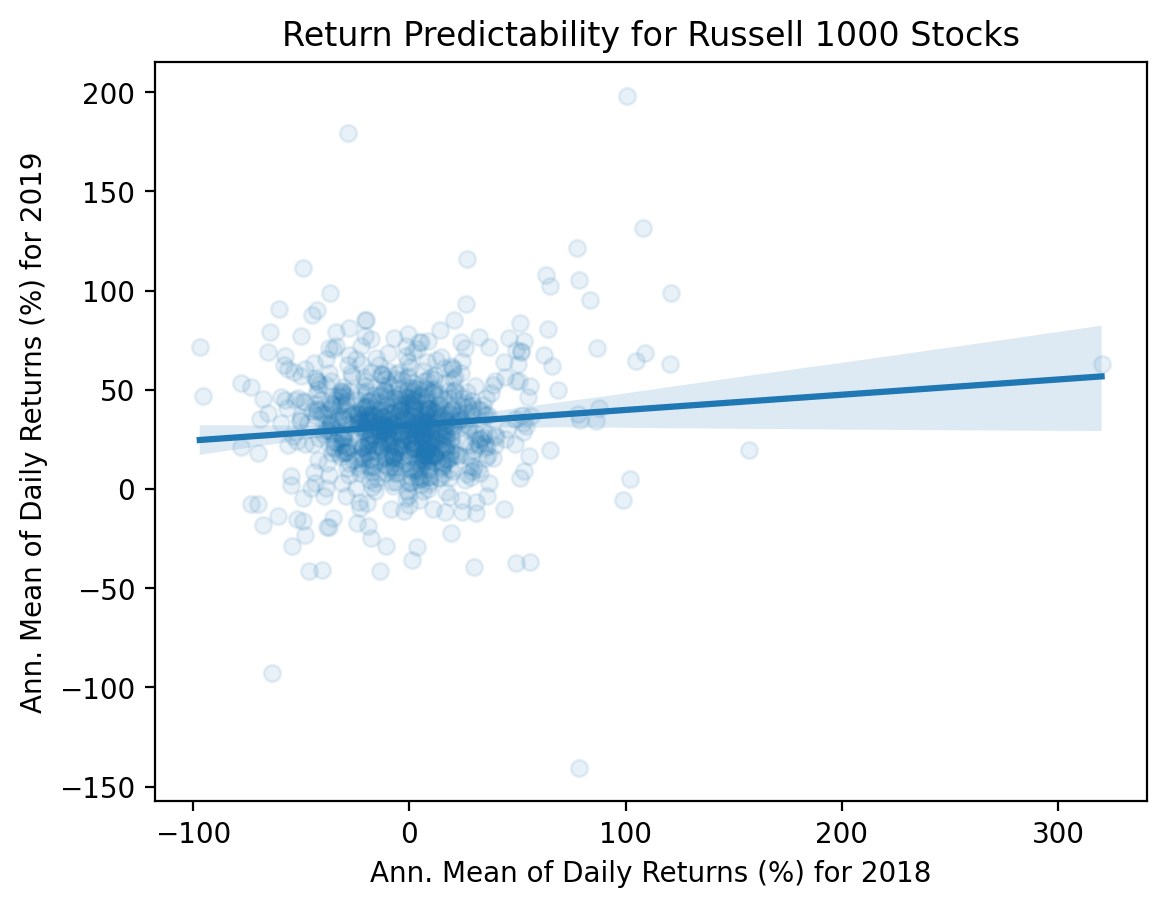

In [18]:
df_1['mean'].pipe(scatter, x=time, y=timep1)
plt.xlabel(f'Ann. Mean of Daily Returns (%) for {time}')
plt.ylabel(f'Ann. Mean of Daily Returns (%) for {timep1}')
plt.title('Return Predictability for Russell 1000 Stocks')
plt.show()

In [19]:
df_1['mean'].pipe(
    stats_corr, 
    sub=f'Ann. Means of Daily Returns (%) for {time} and {timep1}',
)

Statistic,rho
Sample,
All Values,0.098793
Trim 5% Outliers,-0.057586


### Task 2: Does volatility in year $t$ predict volatility in year $t+1$?

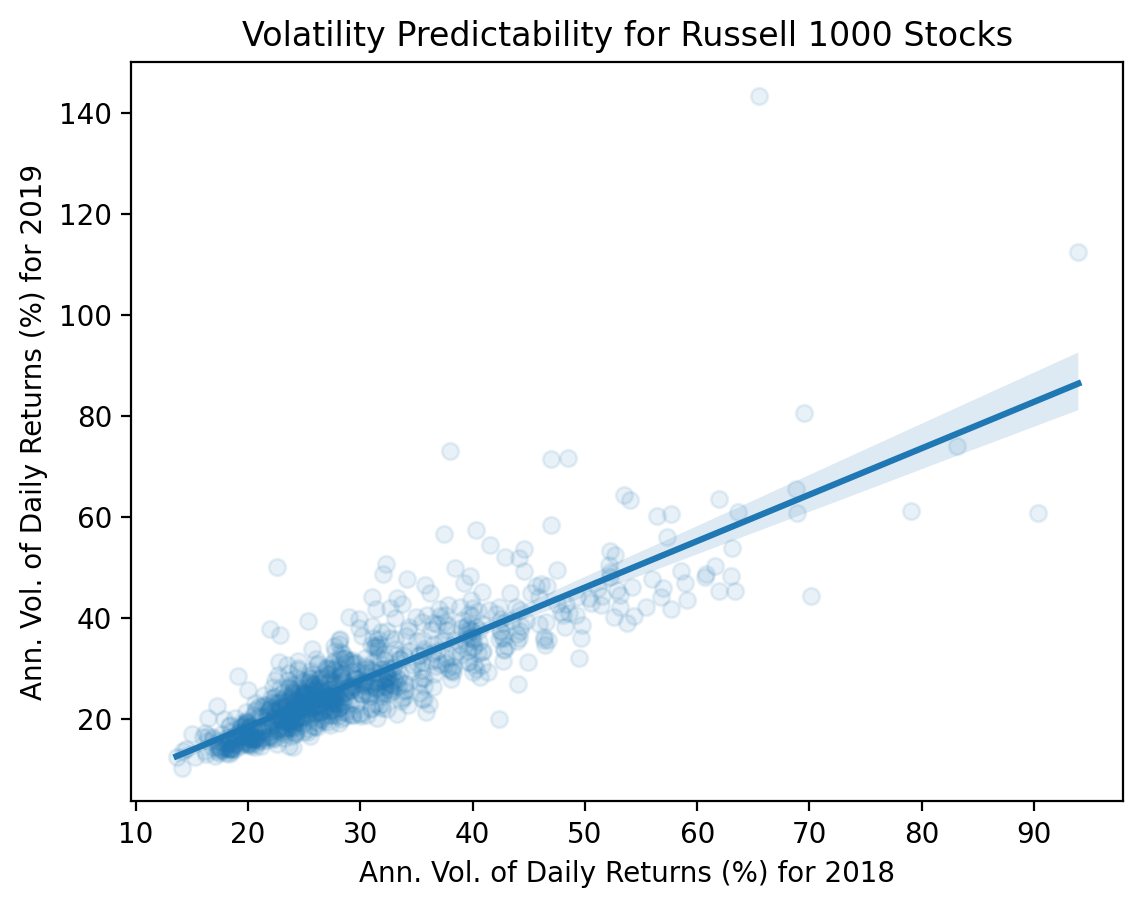

In [20]:
df_1['std'].pipe(scatter, x=time, y=timep1)
plt.xlabel(f'Ann. Vol. of Daily Returns (%) for {time}')
plt.ylabel(f'Ann. Vol. of Daily Returns (%) for {timep1}')
plt.title('Volatility Predictability for Russell 1000 Stocks')
plt.show()

In [21]:
df_1['std'].pipe(
    stats_corr,
    sub=f'Ann. Vol. of Daily Returns (%) for {time} and {timep1}'
)

Statistic,rho
Sample,
All Values,0.844335
Trim 5% Outliers,0.792912


### Task 3: Do Sharpe Ratios in year $t$ predict Sharpe Ratios in year $t+1$?

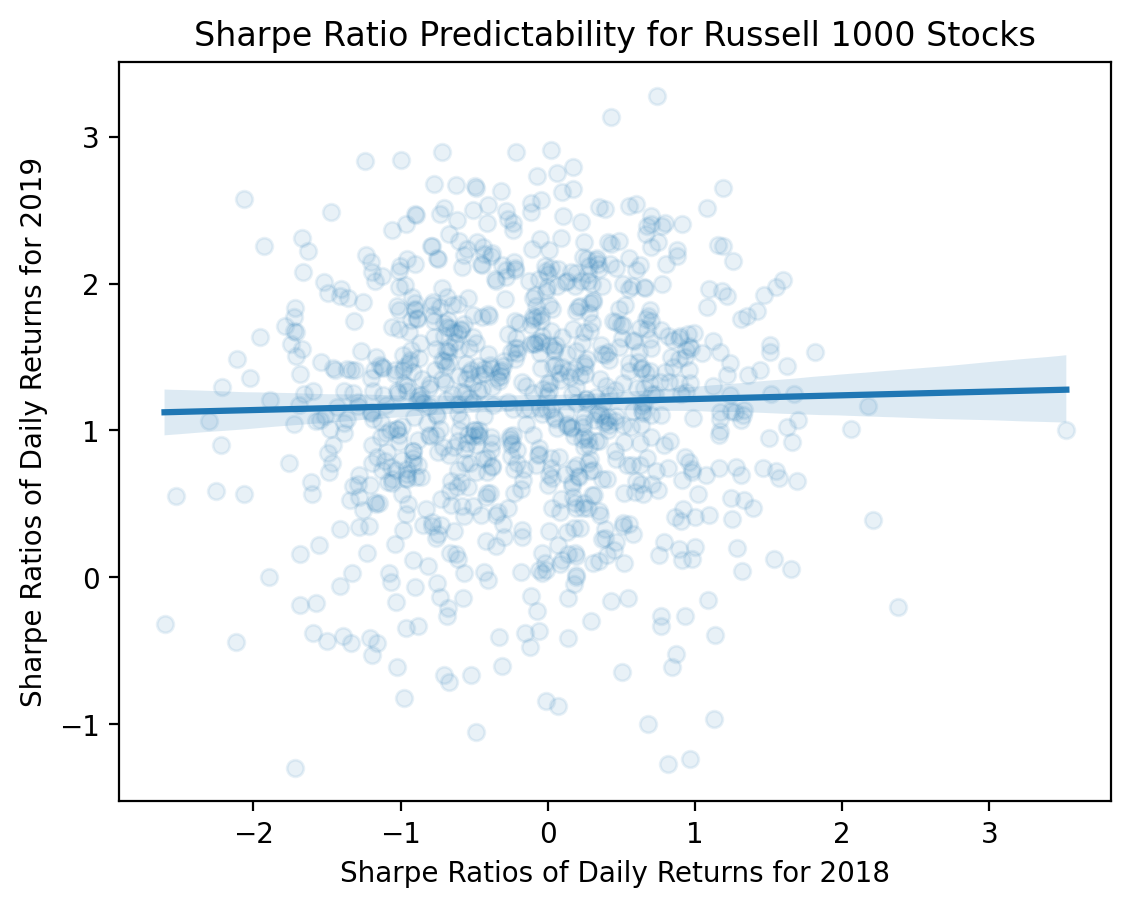

In [22]:
df_1['sharpe'].pipe(scatter, x=time, y=timep1)
plt.xlabel(f'Sharpe Ratios of Daily Returns for {time}')
plt.ylabel(f'Sharpe Ratios of Daily Returns for {timep1}')
plt.title('Sharpe Ratio Predictability for Russell 1000 Stocks')
plt.show()

In [23]:
df_1['sharpe'].pipe(
    stats_corr, 
    sub=f'Sharpe Ratios of Daily Returns for {time} and {timep1}'
)

Statistic,rho
Sample,
All Values,0.027713
Trim 5% Outliers,0.042822


### Task 4: Do CAPM betas in year $t$ predict CAPM betas in year $t+1$?

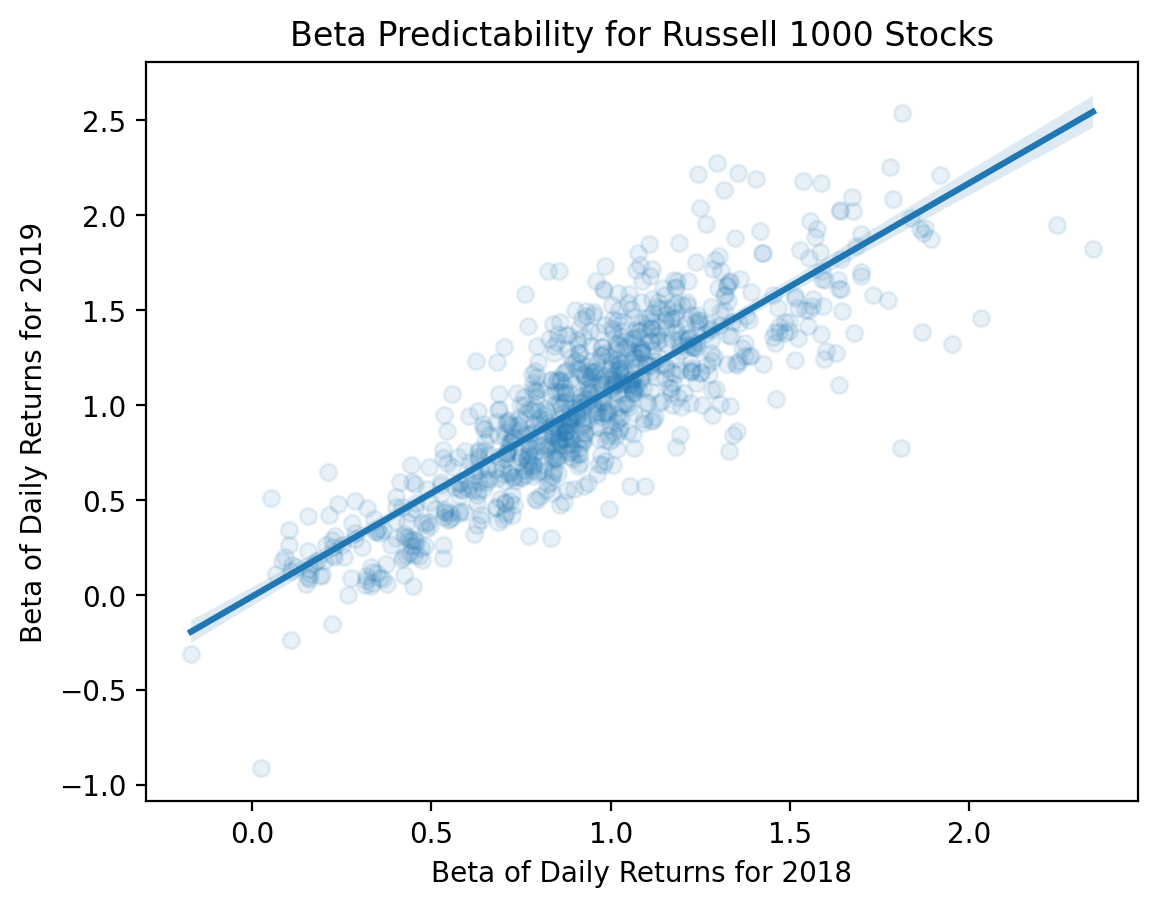

In [24]:
df_1['beta'].pipe(scatter, x=time, y=timep1)
plt.xlabel(f'Beta of Daily Returns for {time}')
plt.ylabel(f'Beta of Daily Returns for {timep1}')
plt.title('Beta Predictability for Russell 1000 Stocks')
plt.show()

In [25]:
df_1['beta'].pipe(
    stats_corr, 
    sub=f'Betas of Daily Returns for {time} and {timep1}'
)

Statistic,rho
Sample,
All Values,0.840941
Trim 5% Outliers,0.800896


### Task 5: Does volatility in year $t$ predict *mean returns* in year $t+1$?

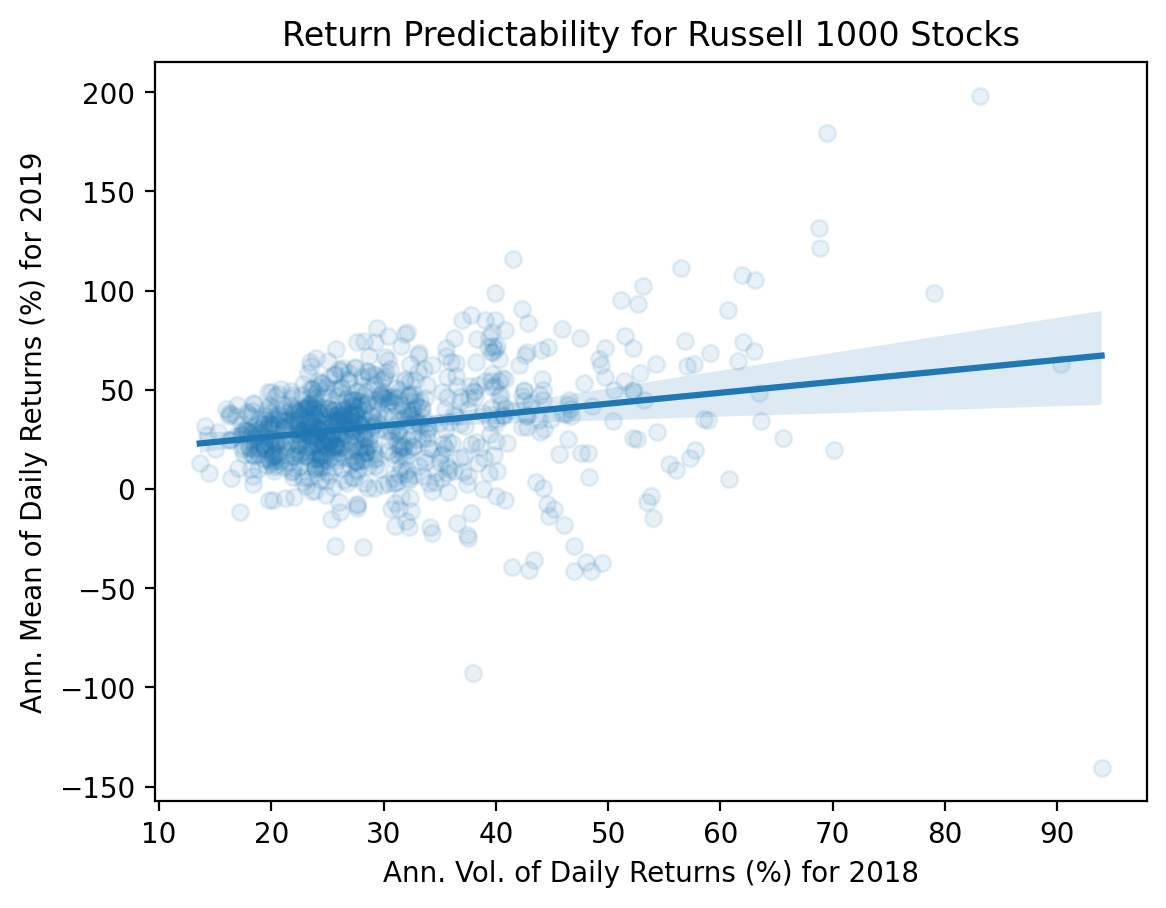

In [26]:
(
    df_1
    [[('std', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(scatter, x=time, y=timep1)
)
plt.xlabel(f'Ann. Vol. of Daily Returns (%) for {time}')
plt.ylabel(f'Ann. Mean of Daily Returns (%) for {timep1}')
plt.title('Return Predictability for Russell 1000 Stocks')
plt.show()

In [27]:
(
    df_1
    [[('std', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(
        stats_corr, 
        sub=f'Ann. Mean of Daily Returns (%) for {time} and Ann. Vol. of Daily Returns (%) for {timep1}'
    )
)

Statistic,rho
Sample,
All Values,0.235243
Trim 5% Outliers,0.119379


### Task 6: Does CAPM beta in year $t$ predict *mean returns* in year $t+1$?

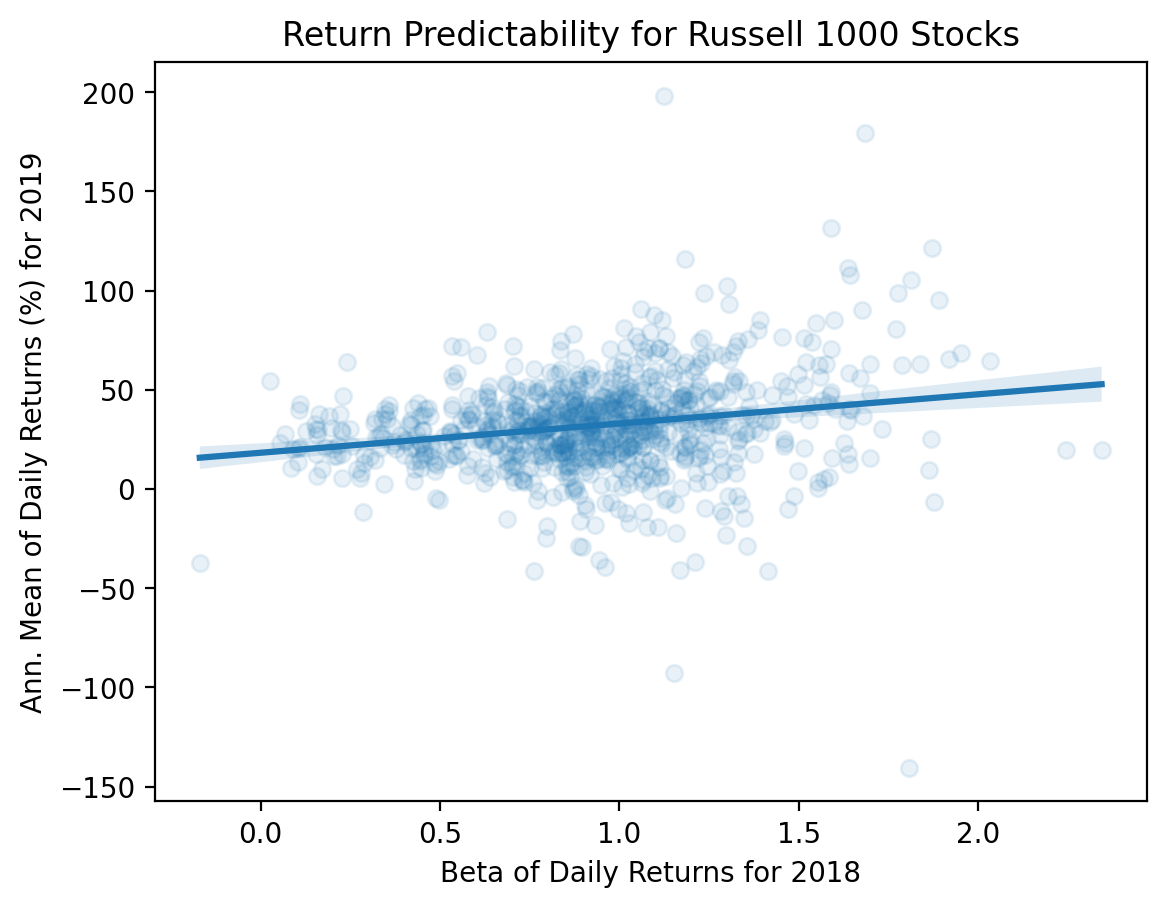

In [28]:
(
    df_1
    [[('beta', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(scatter, x=time, y=timep1)
)
plt.xlabel(f'Beta of Daily Returns for {time}')
plt.ylabel(f'Ann. Mean of Daily Returns (%) for {timep1}')
plt.title('Return Predictability for Russell 1000 Stocks')
plt.show()

In [29]:
(
    df_1
    [[('beta', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(
        stats_corr, 
        sub=f'Ann. Mean of Daily Returns (%) for {time} and Beta of Daily Returns for {timep1}'
    )
)

Statistic,rho
Sample,
All Values,0.213337
Trim 5% Outliers,0.138294


## Portfolios I

For this section, create 100 random portfolios of 50 stocks each from the daily returns in `returns`.
Equally weight these portfolios and rebalance them daily.
Use the same stocks and years $t$ and $t+1$ as the previous section.

### Task 7: Does volatility in year $t$ predict *mean returns* in year $t+1$?

In [30]:
n_stocks = 50
n_ports = 100

df_2 = (
    pd.concat(
        [
            returns
            .loc[time:timep1]
            .dropna(axis=1)
            .sample(n=n_stocks, axis=1, random_state=i)
            .mean(axis=1) 
            for i 
            in range(n_ports)
        ], 
        axis=1
    )
    .pipe(stats_all_ann)
)

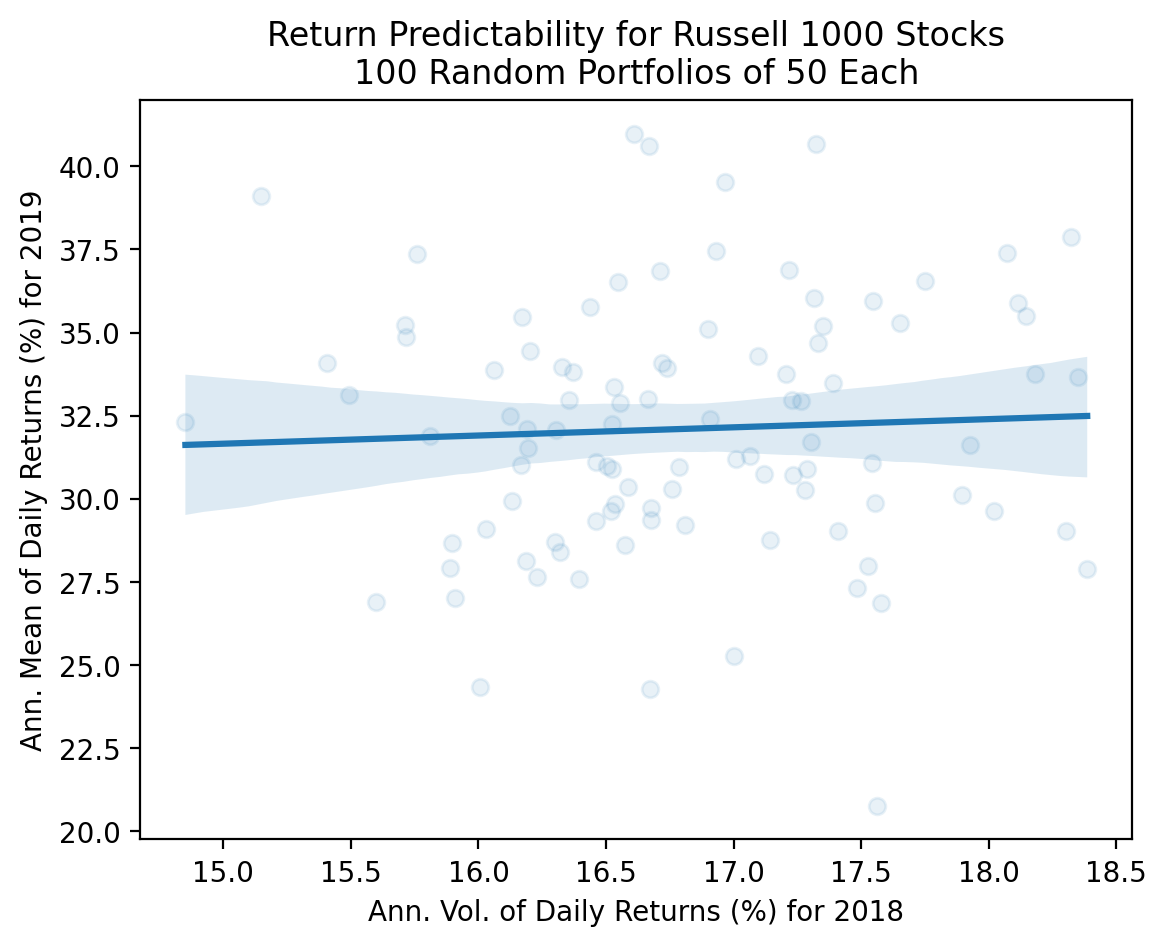

In [31]:
(
    df_2
    [[('std', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(scatter, x=time, y=timep1)
)
plt.xlabel(f'Ann. Vol. of Daily Returns (%) for {time}')
plt.ylabel(f'Ann. Mean of Daily Returns (%) for {timep1}')
plt.title(f'Return Predictability for Russell 1000 Stocks\n{n_ports} Random Portfolios of {n_stocks} Each')
plt.show()

In [32]:
(
    df_2
    [[('std', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(
        stats_corr, 
        sub=f'Ann. Mean of Daily Returns (%) for {time} and Ann. Vol. of Daily Returns (%) for {timep1}'
    )
)

Statistic,rho
Sample,
All Values,0.049628
Trim 5% Outliers,0.105950


#### Comparison of Single Stocks and Portfolios

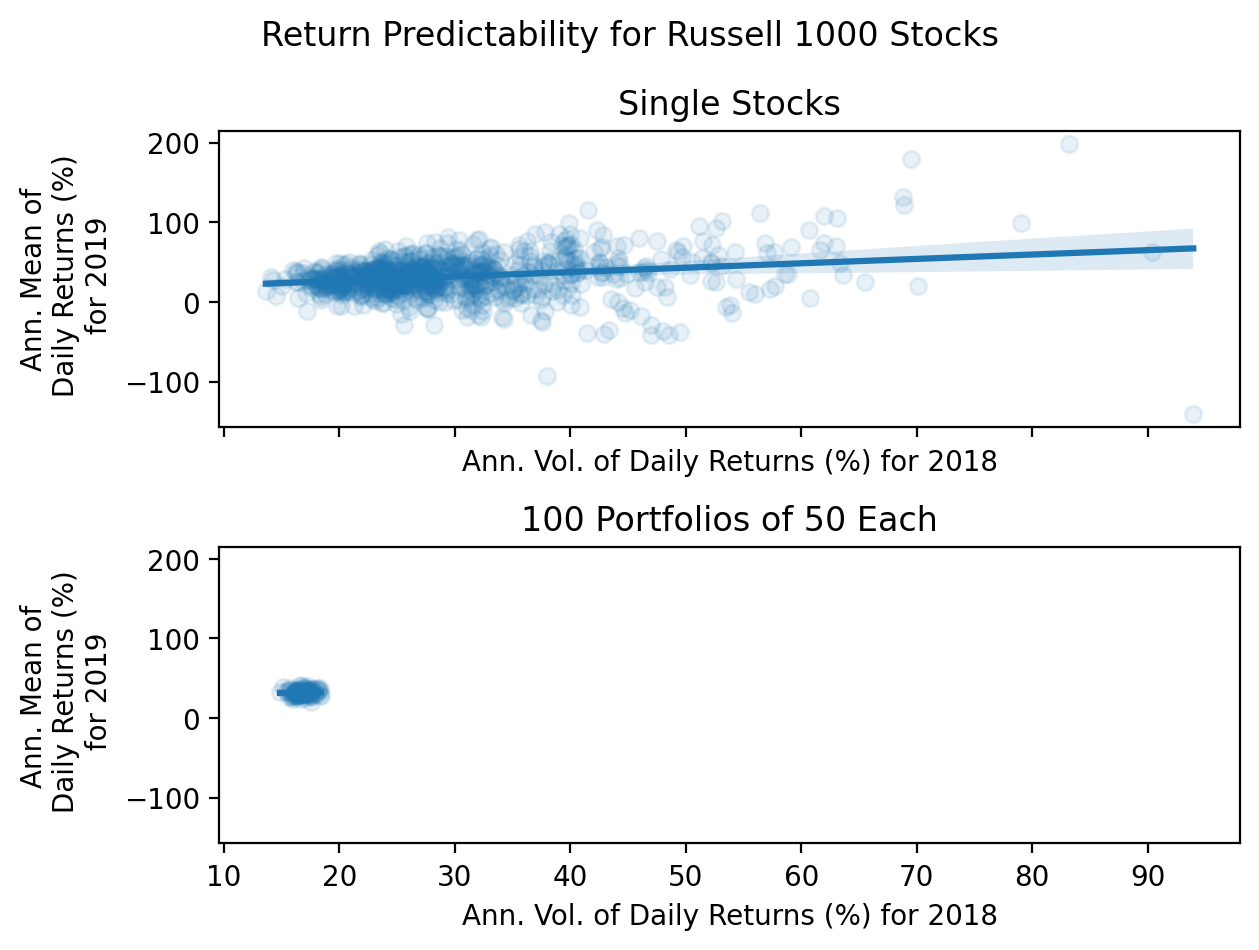

In [33]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
df_1[[('std', time), ('mean', timep1)]].droplevel(level=0, axis=1).pipe(scatter, x=time, y=timep1, ax=ax[0])
ax[0].set_title('Single Stocks')
ax[0].set_xlabel(f'Ann. Vol. of Daily Returns (%) for {time}')
ax[0].set_ylabel(f'Ann. Mean of\n Daily Returns (%)\n for {timep1}')
df_2[[('std', time), ('mean', timep1)]].droplevel(level=0, axis=1).pipe(scatter, x=time, y=timep1, ax=ax[1])
ax[1].set_title(f'{n_ports} Portfolios of {n_stocks} Each')
plt.suptitle('Return Predictability for Russell 1000 Stocks')
ax[1].set_xlabel(f'Ann. Vol. of Daily Returns (%) for {time}')
ax[1].set_ylabel(f'Ann. Mean of\n Daily Returns (%)\n for {timep1}')
plt.tight_layout()
plt.show()

### Task 8: Does CAPM beta in year $t$ predict *mean returns* in year $t+1$?

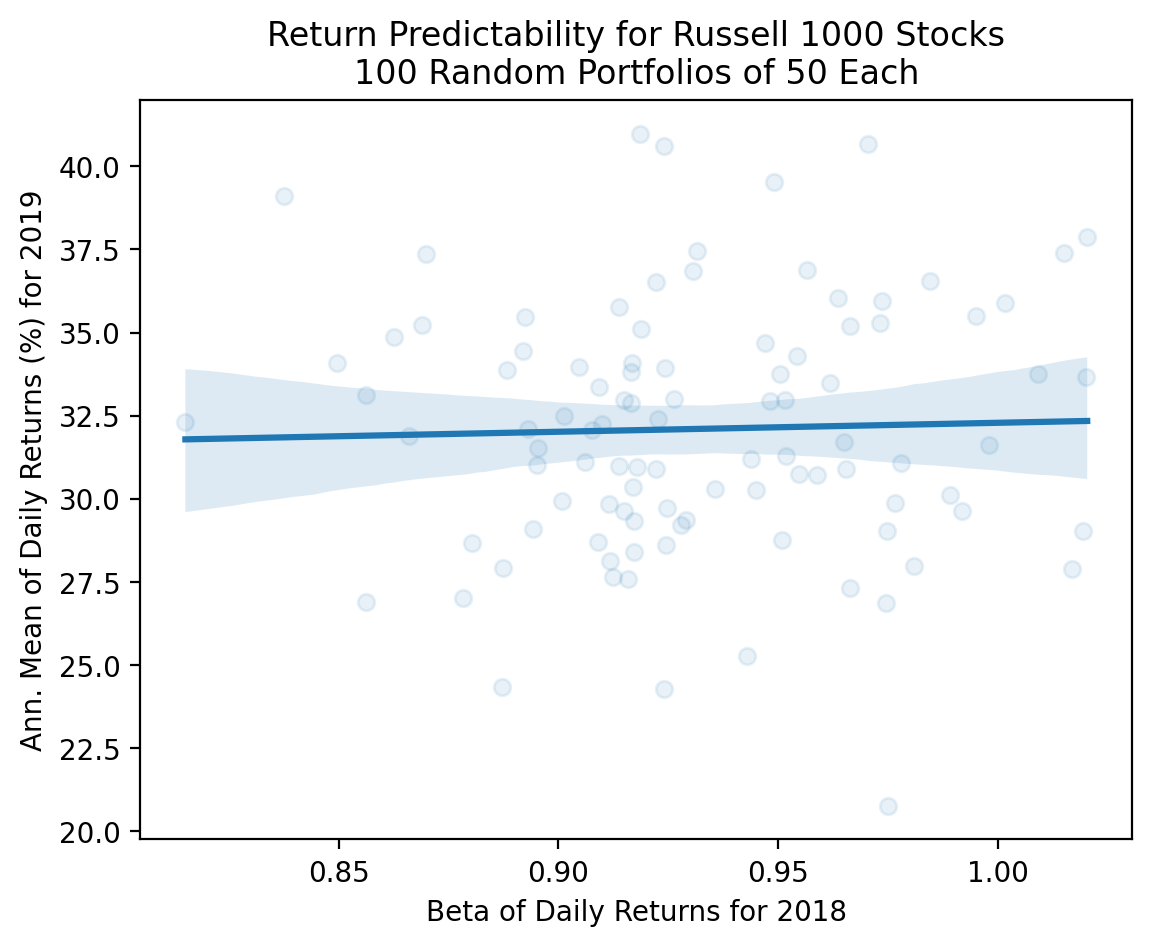

In [34]:
(
    df_2
    [[('beta', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(scatter, x=time, y=timep1)
)
plt.xlabel(f'Beta of Daily Returns for {time}')
plt.ylabel(f'Ann. Mean of Daily Returns (%) for {timep1}')
plt.title(f'Return Predictability for Russell 1000 Stocks\n{n_ports} Random Portfolios of {n_stocks} Each')
plt.show()

In [35]:
(
    df_2
    [[('beta', time), ('mean', timep1)]]
    .droplevel(level=0, axis=1)
    .pipe(
        stats_corr, 
        sub=f'Ann. Means of Daily Returns (%) for {timep1} and Beta of Daily Returns for {time}'
    )
)

Statistic,rho
Sample,
All Values,0.030935
Trim 5% Outliers,0.049911


#### Comparison of Single Stocks and Portfolios

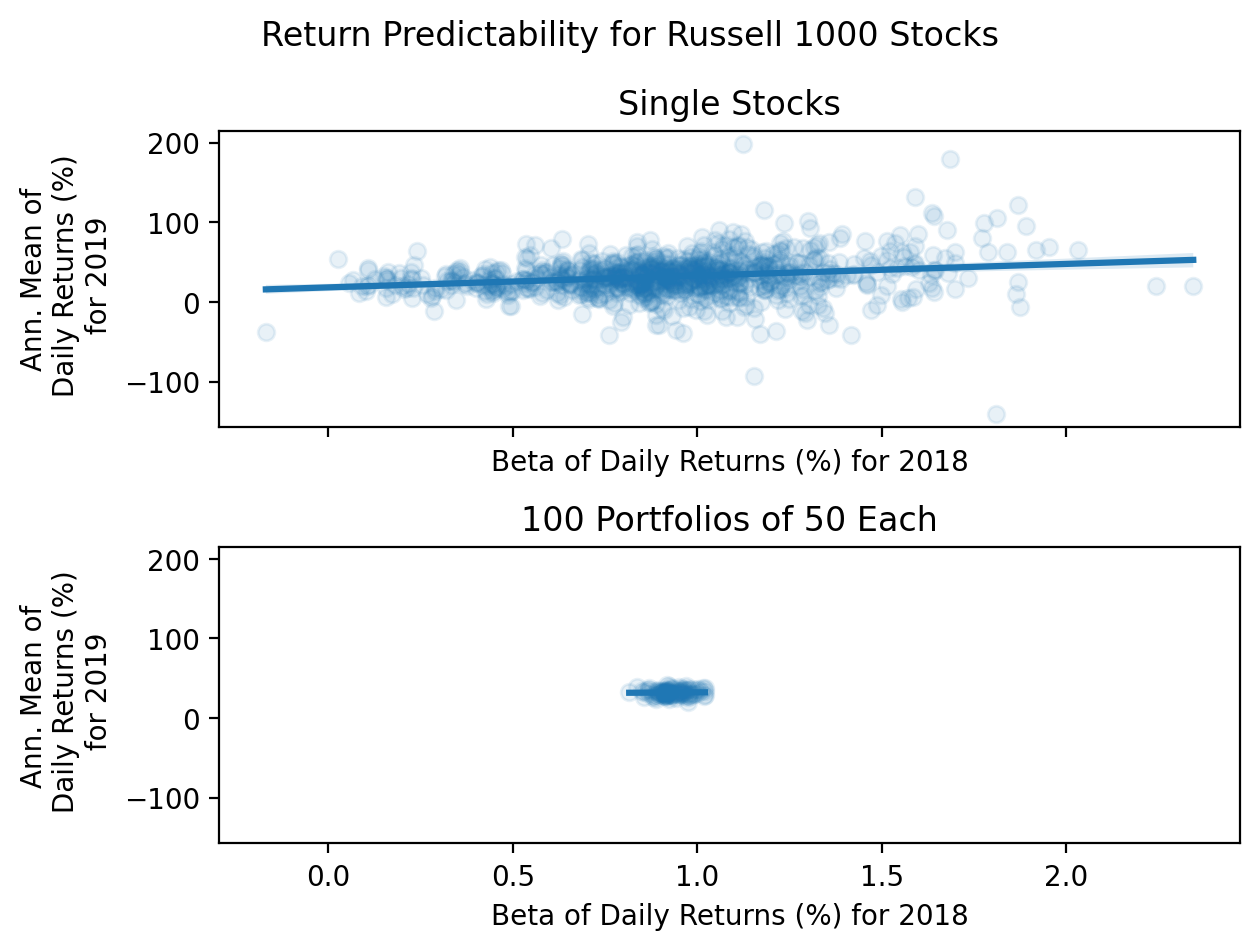

In [36]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
df_1[[('beta', time), ('mean', timep1)]].droplevel(level=0, axis=1).pipe(scatter, x=time, y=timep1, ax=ax[0])
ax[0].set_title('Single Stocks')
ax[0].set_xlabel(f'Beta of Daily Returns (%) for {time}')
ax[0].set_ylabel(f'Ann. Mean of\n Daily Returns (%)\n for {timep1}')
df_2[[('beta', time), ('mean', timep1)]].droplevel(level=0, axis=1).pipe(scatter, x=time, y=timep1, ax=ax[1])
ax[1].set_title(f'{n_ports} Portfolios of {n_stocks} Each')
plt.suptitle('Return Predictability for Russell 1000 Stocks')
ax[1].set_xlabel(f'Beta of Daily Returns (%) for {time}')
ax[1].set_ylabel(f'Ann. Mean of\n Daily Returns (%)\n for {timep1}')
plt.tight_layout()
plt.show()

## Portfolios II

Calculate monthly volatility and total return for *every stock* and *every month* in `returns`.
Drop stock-months with fewer than 15 returns.
Each month, assign these stocks to one of five portfolios based on their volatility during the previous month.
Equally weight these portfolios and rebalance them monthly.

### Task 9: Do high volatility portfolios have high mean returns and Sharpe Ratios?

In [37]:
df_3 = (
    pd.concat(
        [
            returns.resample('M', kind='period').std().shift(),
            returns.resample('M', kind='period').count().shift(),
            returns.add(1).resample('M', kind='period').prod().sub(1),
            returns.resample('M', kind='period').count()
        ], 
        keys=['std_lag', 'count_lag', 'ret', 'count'], 
        names=['Variable', 'Ticker'], 
        axis=1
    )
    .stack()
    .query('(count_lag >= 15) & (count >= 15)')
    .assign(Portfolio = lambda x: x.groupby('Date')['std_lag'].transform(pd.qcut, q=5, labels=False))
    .groupby(['Date', 'Portfolio'])
    ['ret']
    .mean()
    .unstack()
    .rename(columns=lambda x: 1 + x)
)

In [38]:
df_3.describe()

Portfolio,1,2,3,4,5
count,731.0000,731.0000,731.0000,731.0000,731.0000
mean,0.0103,0.0120,0.0123,0.0152,0.0204
std,0.0358,0.0436,0.0490,0.0558,0.0787
min,-0.1472,-0.2354,-0.2503,-0.2746,-0.3272
25%,-0.0099,-0.0117,-0.0149,-0.0170,-0.0227
50%,0.0132,0.0151,0.0157,0.0174,0.0182
75%,0.0311,0.0367,0.0413,0.0481,0.0641
max,0.1329,0.1950,0.1781,0.2206,0.4369


In [39]:
df_4 = (
    pd.concat(
        [
            df_3.apply(mean, ann=12),
            df_3.apply(std, ann=np.sqrt(12)),
            df_3.apply(sharpe, rf=ff['RF'].add(1).resample('M', kind='period').prod().sub(1), ann=np.sqrt(12))
        ],
        axis=1,
        keys=['Mean', 'Standard Deviation', 'Sharpe Ratio'],
        names=['Statistic']
    )
)

In [40]:
df_4

Statistic,Mean,Standard Deviation,Sharpe Ratio
Portfolio,,,
1,12.3963,12.4139,0.6481
2,14.3477,15.0877,0.6634
3,14.7852,16.9639,0.6159
4,18.1812,19.3437,0.7159
5,24.5168,27.2776,0.7387


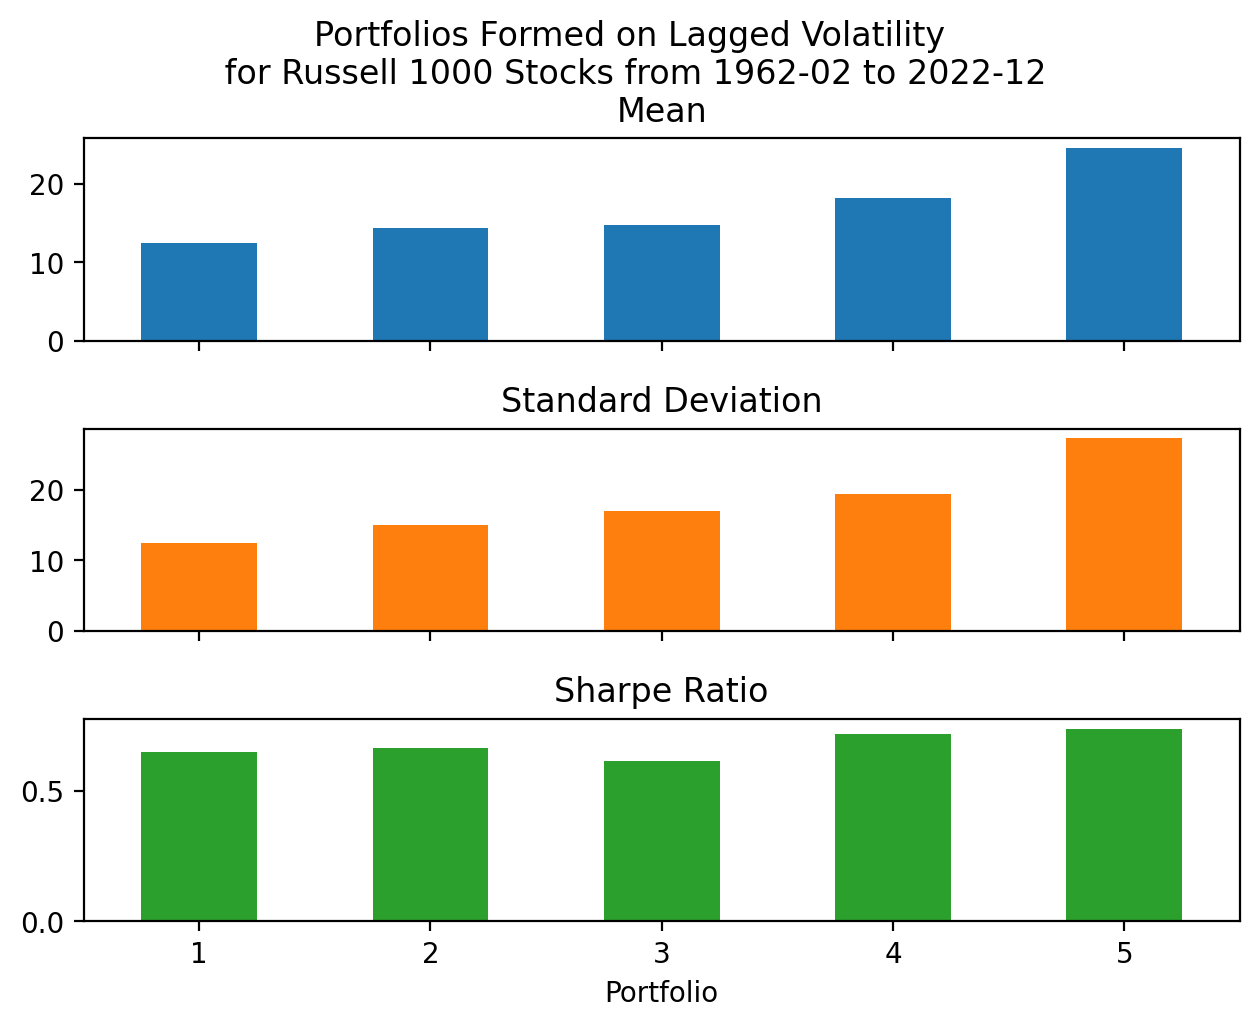

In [41]:
df_4.plot(kind='bar', subplots=True, legend=False)
plt.tight_layout()
plt.suptitle(f'Portfolios Formed on Lagged Volatility\n for Russell 1000 Stocks from {df_3.index[0]} to {df_3.index[-1]}', y=1.05)
plt.xticks(rotation=0)
plt.show()

## Discussion

### Task 10: Discuss and explain any limitations of your analysis above

- Selection bias
    - Two years
    - Russell 1000 stocks
- Survivorship bias in Yahoo! Finance database
- Could try larger portfolios and more portfolios
- Means, volatilities, Sharpe Ratios, and $\beta$s are not the only measures of risk and return

# Criteria

1. All tasks are worth ten points
1. Discuss and explain your findings for all ten tasks
1. Here are a few more tips
    1. ***Your goal is to convince me of your calculations and conclusions***
    1. I typically find figures most convincing
    1. If you use correlations, consider how a handful of outliers may affect your findings
    1. Remove unnecessary code, outputs, and print statements
    1. Write functions for calculations that you expect to use more than once
    1. ***I will not penalize code style, but I will penalize submissions that are difficult to follow or do not follow these instructions***
1. How to submit your project
    1. Restart your kernel, run all cells, and save your notebook
    1. Export your notebook to PDF (`File > Save And Export Notebook As ... > PDF` in JupyterLab)
        1. If this export does not work, you can either (1) Install MikTeX on your laptop with the default settings or (2) use DataCamp Workspace to export your notebook to PDF
        1. You do not need to re-run your notebook to export it because notebooks store output cells
    1. Upload your notebook and PDF to Canvas
    1. Upload your PDF only to Gradescope and tag your teammates
    1. Gradescope helps me give better feedback more quickly, but I do not consider it reliable for sharing and storing your submission files